<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/cyclicLR_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import optim
from torch import nn
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import CyclicLR

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor()                                
])

dataset = datasets.MNIST('./data', train=False, download=True)

In [3]:
class LoadData(Dataset):
  def __init__(self, data, target, transform):
    super().__init__()
    self.data = data
    self.target = target
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return (self.transform(self.data[idx]), self.target[idx])


In [13]:
bs = 32
trainloader = DataLoader(LoadData(dataset.data[:8000], dataset.targets[:8000], transform), bs, shuffle=True)
valloader = DataLoader(LoadData(dataset.data[8000:], dataset.targets[8000:], transform), bs)

In [14]:
for data, label in trainloader:
  print(data.shape, label)
  break

for data, label in valloader:
  print(data.shape, label)
  break

torch.Size([32, 1, 28, 28]) tensor([8, 6, 1, 7, 5, 9, 0, 2, 8, 2, 0, 7, 7, 1, 2, 3, 4, 1, 1, 3, 4, 2, 5, 9,
        7, 5, 4, 0, 5, 1, 1, 5])
torch.Size([32, 1, 28, 28]) tensor([4, 9, 9, 7, 1, 1, 9, 0, 7, 8, 3, 4, 8, 6, 3, 8, 0, 9, 6, 2, 1, 0, 1, 0,
        6, 2, 3, 8, 9, 0, 7, 2])


In [15]:
def validate(dataloader):
  correct = 0.0
  for inp, output in dataloader:
    out = model(inp.to(device))

    loss = criterion(out, output.to(device))

    out = torch.argmax(out.data, 1)

    correct += (out==output.to(device)).sum()

  return loss.item(), (correct.item()/(bs*len(valloader)))

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=False)

# for params in model.parameters():
#   params.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

scheduler = CyclicLR(opt, base_lr=1e-6, max_lr=3e-2, step_size_up=2*len(trainloader), cycle_momentum=False)

In [20]:
model = model.to(device)

In [21]:
epochs = 4
acc = []
lr = []
val_loss = []

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for data, labels in tqdm(trainloader, total=len(trainloader), leave=False):

    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

    lr.append(opt.param_groups[0]['lr'])

    scheduler.step()

  model.eval()
  valid = validate(valloader)
  val_loss.append(valid[0])
  acc.append(valid[1])

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {valid[0]}\tacc: {valid[1]}\n") 

Epoch: 1/4	train_loss: 0.3036567270755768	val_loss: 0.8396509289741516	acc: 0.8184523809523809



Epoch: 2/4	train_loss: 0.6586152911186218	val_loss: 0.08626355975866318	acc: 0.9052579365079365



Epoch: 3/4	train_loss: 0.04606937989592552	val_loss: 0.0030693954322487116	acc: 0.9756944444444444



Epoch: 4/4	train_loss: 0.021718330681324005	val_loss: 0.001357824308797717	acc: 0.9826388888888888



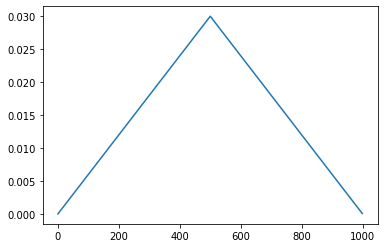

In [22]:
plt.plot(lr)

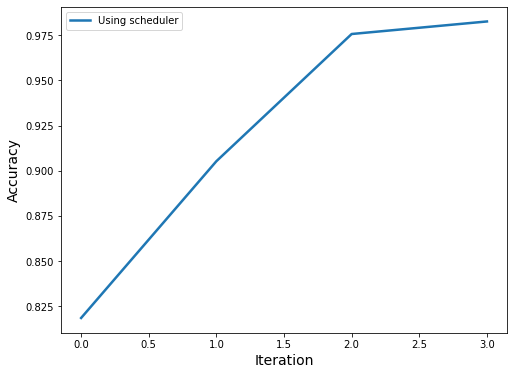

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(acc, label="Using scheduler", linewidth=2.5)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.savefig("sched.jpg")